# Transformer Pre-processing

In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import colormaps
import os 

## Position Encoding
It is a standard practice in natural language processing tasks to convert sentences into tokens before feeding texts into a language model. Each token is then converted into a numerical vector of fixed length called an embedding, which captures the meaning of the words. In the Transformer architecture, a positional encoding vector is added to the embedding to pass positional information throughout the model.

The meaning of these vectors can be difficult to grasp solely by examining the numerical representations, but visualizations can help give some intuition as to the semantic and positional similarity of the words. When embeddings are reduced to two dimensions and plotted, semantically similar words appear closer together, while dissimilar words are plotted farther apart. A similar exercise can be performed with positional encoding vectors - words that are closer in a sentence should appear closer when plotted on a Cartesian plane, and when farther in a sentence, should appear farther on the plane.

We will create a series of visualizations of word embeddings and positional encoding vectors to gain intuition into how positional encodings affect word embeddings and help transport sequential information through the Transformer architecture.

### Positional encoding visualizations

Now, we create a function which creates positional encodings for transformer model. Positional encoding is crucial in transformer architectures because they need a way to understand the order/position of elements in a sequence, since transformers process all elements in parallel rather than sequentially.

In [2]:
def positional_encoding(positions, d): 
    """
    Arguments: 
    positions: maximum sequence length to encode
    d: dimension of the encoding vector 
    """

    # Create a sequence of numbers from 0 to positions-1
    pos_seq = np.arange(positions)

    # add a new axis to make it a column vector
    pos_column = pos_seq[:, np.newaxis]

    # create the denominator term 
    # np.arange(d) creates indices for each dimension [0, 1 , 2 ..... d-1]
    # //2 divides these indices by 2 
    # the result is used in the power of 10000 
    denominator = np.power(10000, (2 * (np.arange(d) // 2)) / np.float32(d))

    # divide the column vector by the denominator
    angle_rads = pos_column / denominator

    # apply sine to even indices in the array(0::2 means start at 0, step by 2)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cosine to odd indices in the array
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1:2])

    # add batch dimension by adding extra axis at the start 
    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

Define the embedding dimension as 100. This value must match the dimensionality of the word embedding. In the "Attention is All You Need" paper, embedding sizes range from 100 to 1024, depending on the task. The authors also use a maximum sequence length ranging from 40 to 512 depending on the task. Define the maximum sequence length to be 100, and the maximum number of words to be 64.

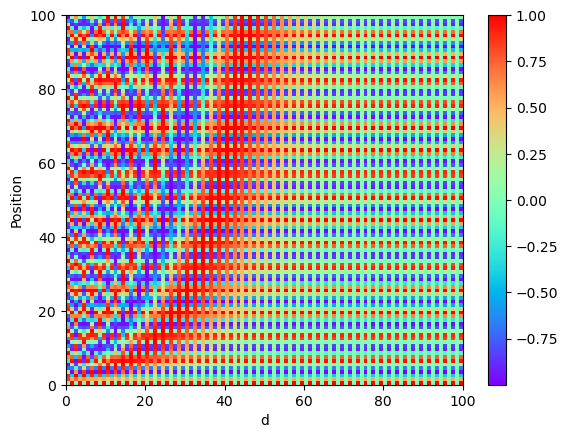

In [3]:
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 100 
MAX_NB_WORDS = 64

pos_encoding = positional_encoding(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)

plt.pcolormesh(pos_encoding[0], cmap='rainbow')
plt.xlabel('d')
plt.xlim(0, EMBEDDING_DIM)
plt.ylabel('Position')
plt.colorbar()
plt.show()

The Key Points are: 
- The norm of each of the vectors is always a constant: this means that the length of each row vector in the matrix is always the same fixed value. The "norm" here refers to the vector`s length calculated using pythagoreas theorem.
- This constant norm length is true "no matter what the value of pos is".
- Because the norm is constant, the dot product of two positional encoding vector is not affected by the scale of the vector. the dot product is a way to measure similarity between vectors. Since all vectors have the same length, their similarities are not impacted by vector scale.

In [4]:
pos = 70
k = 2

# calculate euclidean distance 
print(tf.norm(pos_encoding[0, pos, :] - pos_encoding[0, pos + k, :]))
print(tf.norm(pos_encoding[0, pos + k, :] - pos_encoding[0, pos, :]))

tf.Tensor(11.5301895, shape=(), dtype=float32)
tf.Tensor(11.5301895, shape=(), dtype=float32)


## Comparing Positional Encodings
### Correlation 

The above positional coding matrix helps to visualize how each vector is unique for every position.
However, It is still not clear how these vectors can represent the relative position of the words in a sentence. To illustrate this, you will calculate the correlation between pairs of vectors at every single position. A successful positional encoder will produce a perfectly symmetric matrix in which maximum values are located at the main diagonal - vectors in similar positions should have the highest correlation. Following the same logic, the correlation values should get smaller as they move away from the main diagonal.

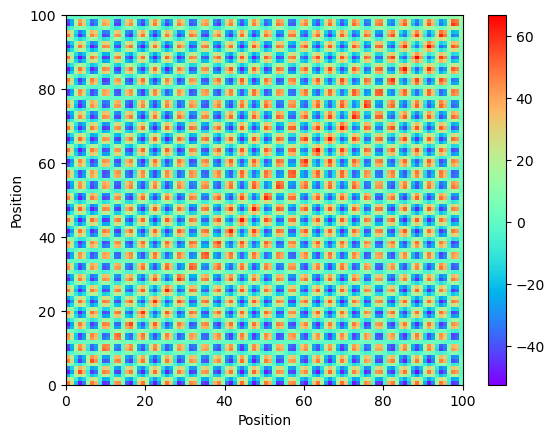

In [5]:
corr = tf.matmul(pos_encoding, pos_encoding, transpose_b=True).numpy()[0]

plt.pcolormesh(corr, cmap='rainbow')
plt.xlabel('Position')
plt.xlim(0, MAX_SEQUENCE_LENGTH)
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Euclidean Distance 
We can also use the euclidean distance instead of the correlation for comparing the positional encoding vectors.

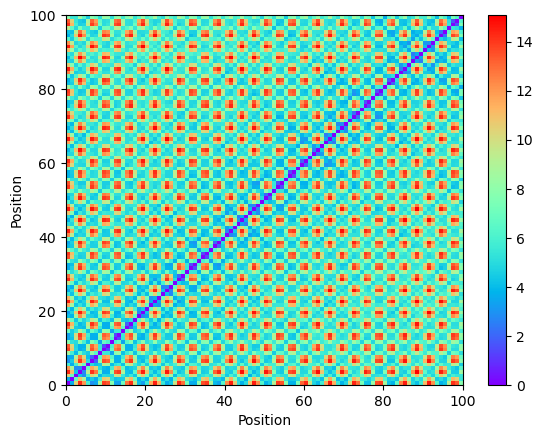

In [6]:
eu = np.zeros((MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH))
for a in range(MAX_SEQUENCE_LENGTH): 
    for b in range(a + 1, MAX_SEQUENCE_LENGTH):
       eu[a, b] = tf.norm(tf.math.subtract(pos_encoding[0, a], pos_encoding[0 , b]))
       eu[b, a] = eu[a, b] 

plt.pcolormesh(eu, cmap='rainbow')
plt.xlabel('Position')
plt.xlim(0, MAX_SEQUENCE_LENGTH)
plt.ylabel('Position')
plt.colorbar()
plt.show()

Now, We can use this visualizations as checks for any positional encodings we create

## Semantic Embedding 

### Load Pretrained Embedding 
To combine a pretrained word embedding with the positional encodings created earlier, start by loading one of the pretrained embeddings from the globe 

In [7]:
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
print('d_model:', embeddings_index['hi'].shape)

Found 400000 word vectors.
d_model: (100,)


These sentences have no meaning! Instead, the sentences are engineered such that:
- Each sentence is composed of sets of words, which have some semantic similarities among each groups.
- In the first sentence similar terms are consecutive, while in the second sentence, the order is random.

In [13]:
texts = ['king queen man woman dog wolf football basketball red green yellow',
         'man queen yellow basketball green dog  woman football  king red wolf']

In [17]:
# Apply tokenization to the above text 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(f'Found {len(word_index)} Unique tokens ')

data = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post', maxlen=MAX_SEQUENCE_LENGTH)
print(data)

Found 11 Unique tokens 
[[ 1  2  3  4  5  6  7  8  9 10 11  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 3  2 11  8 10  5  4  7  1  9  6  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]


To simplify your model, you will only need to obtain the embeddings for the different words that appear in the text you are examining. In this case, you will filter out only the 11 words appearing in our sentences. The first vector will be an array of zeros and will codify all the unknown words.

In [18]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items(): 
    embedding_vector = embeddings_index.get(word) 

    if embedding_vector is not None: 
        # words not found in embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

(12, 100)


Create an embedding layer using the weights extracted from the pretrained glove embeddings

In [19]:
embedding_layer = tf.keras.layers.Embedding(
    len(word_index) + 1, 
    EMBEDDING_DIM, 
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), 
    trainable=False
)

transform the input tokenized data to the embedding using the above layer.

In [20]:
embedding = embedding_layer(data)

## Visualization on Cartesian Plane 
Now, we will create a function that allows you to visualize the encoding of our words in a cartesian plane. We will be using PCA to reduce the 100 features of the glove embedding to only 2 components.


The primary purpose of PCA is to transform a high-dimensional dataset into a lower-dimensional space while retaining as much of the original information (or variance) as possible. This is particularly useful in situations where the dataset has a large number of features (dimensions), which can lead to computational challenges, overfitting, and the curse of dimensionality.

In [23]:
from sklearn.decomposition import PCA 

In [32]:
def plot_words(embedding, sequences, sentence): 
    pca = PCA(n_components=2)
    X_pca_train = pca.fit_transform(embedding[sentence, 0:len(sequences[sentence]), :])

    fig, ax = plt.subplots(figsize=(12, 6))
    plt.rcParams['font.size'] = '12'
    ax.scatter(X_pca_train[:, 0], X_pca_train[:, 1])
    words = list(word_index.keys())

    for i, index in enumerate(sequences[sentence]): 
        ax.annotate(words[index-1], (X_pca_train[i, 0], X_pca_train[i, 1]))

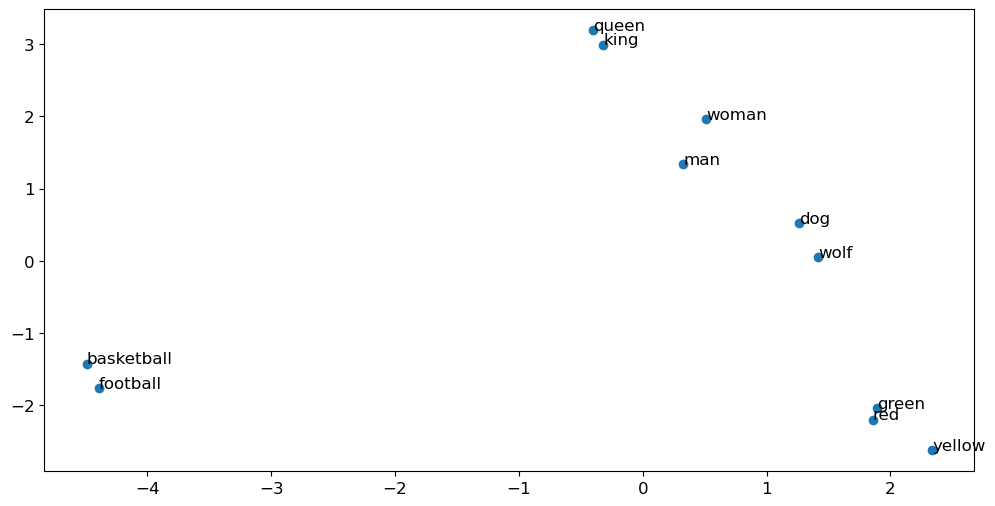

In [33]:
plot_words(embedding, sequences, 0)

Plot the word of embeddings of the second sentence. Recall that the second sentence contains the same words as the first sentence, just in a different order. You can see that the order of the words does not affect the vector representations. 

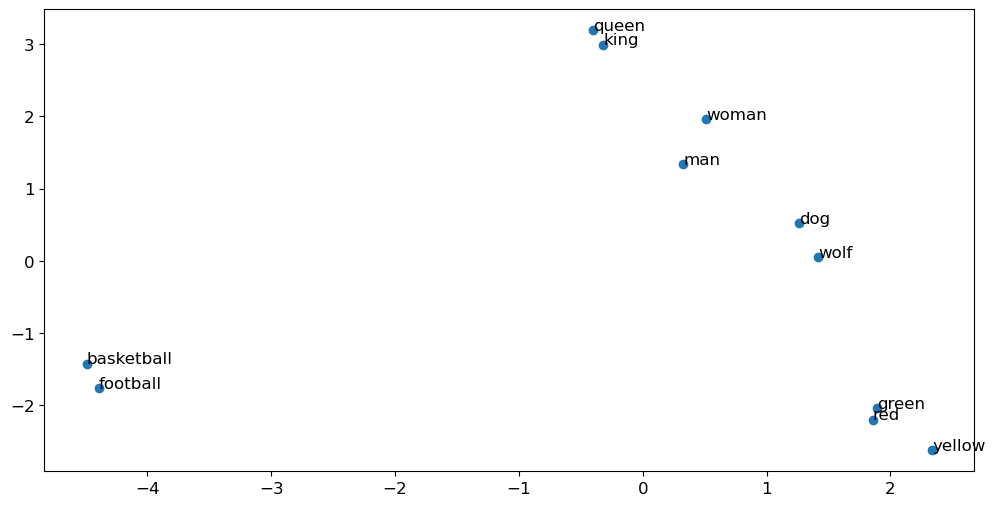

In [34]:
plot_words(embedding, sequences, 1)

## Semantic and Positional embedding 
Now, we will combine the original glove embedding with the positional encoding we calculated earlier.

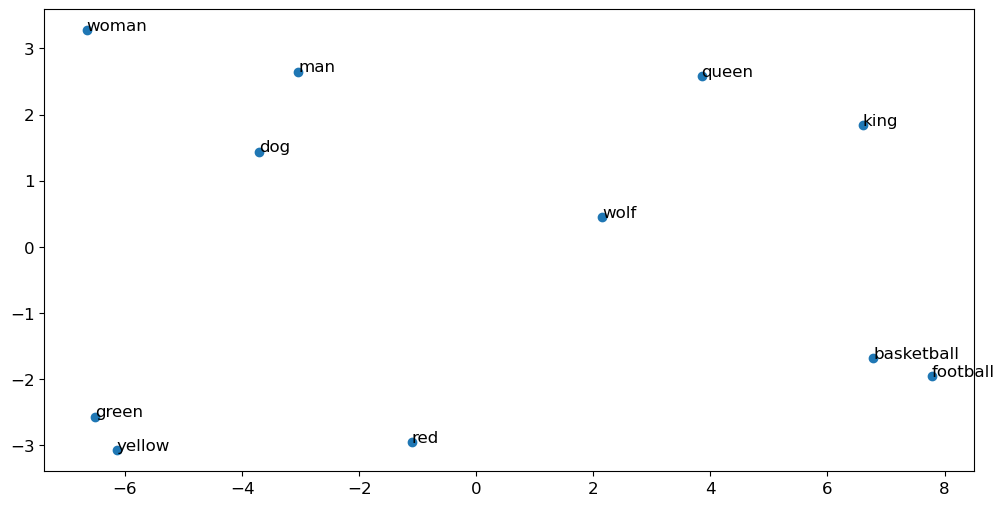

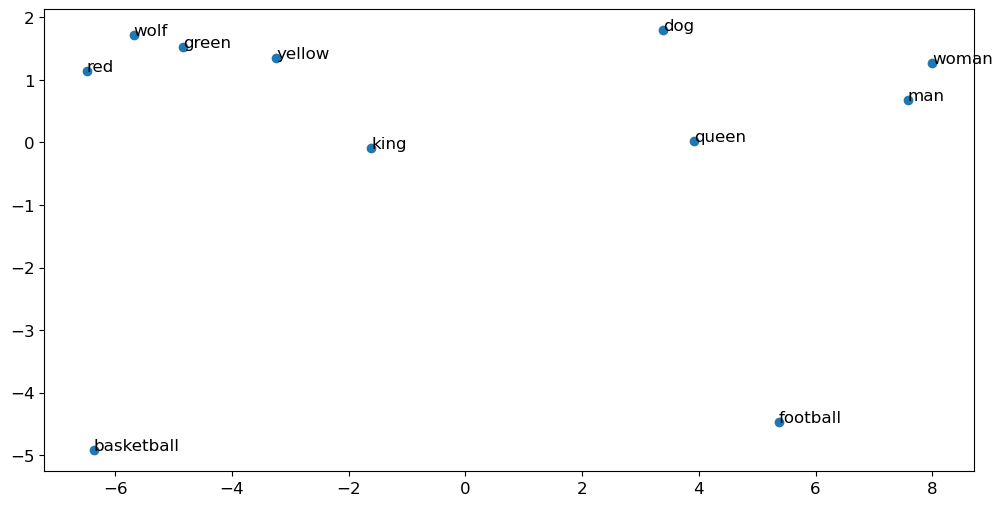

In [35]:
embedding2 = embedding * 1.0 + pos_encoding[:,:,:] * 1.0

plot_words(embedding2, sequences, 0)
plot_words(embedding2, sequences, 1)

Both plots have changed drastically compared to their original counterparts. Notice that in the second image, which corresponds to the sentence in which similar words are not together, very dissimilar words such as `red` and `wolf` appear more close.

Now you can try different relative weights and see how this strongly impacts the vector representation of the words in the sentence.

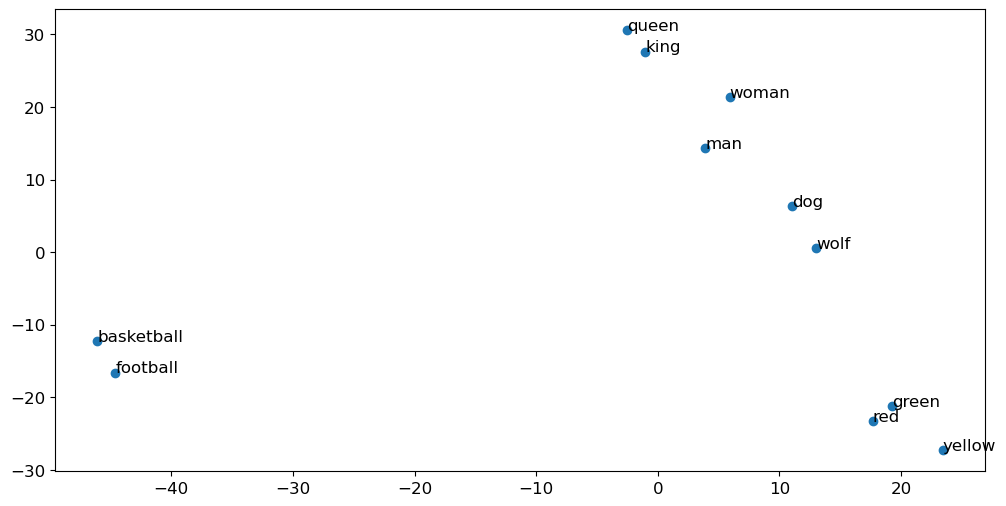

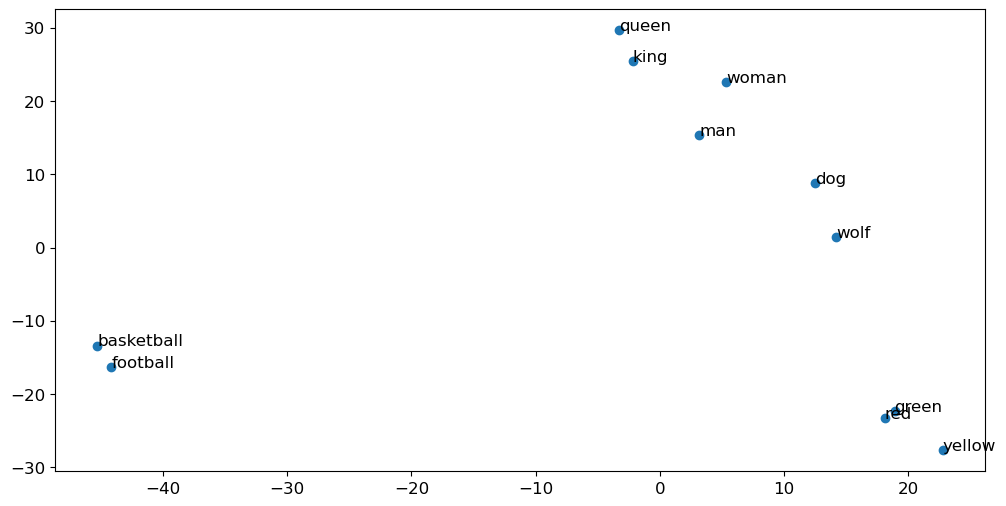

In [47]:
W1 = 10
W2 = 1

embedding2 = embedding * W1 + pos_encoding[:,:,:] * W2 

plot_words(embedding2, sequences, 0)
plot_words(embedding2, sequences, 1)